We're going to take this dataset and build the Pythagorean win expectation for each team each year. We're going to use the NFL Pythagorean exponent, as there appears to be no separate CFB Pythagorean exponent.

In [1]:
import pandas as pd

DATA = '/kaggle/input/college-football-team-stats-2002-to-january-2024/cfb_box-scores_2002-2023.csv'
df = pd.read_csv(filepath_or_buffer=DATA)
df.head()

,season,week,date,time_et,game_type,away,home,rank_away,rank_home,conf_away,...,int_away,int_home,pen_num_away,pen_yards_away,pen_num_home,pen_yards_home,possession_away,possession_home,attendance,tv
0,2002,1.0,2002-08-22,7:30 PM,regular,Colorado State,Virginia,NaN,NaN,mwc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57120.0,NaN
1,2002,1.0,2002-08-23,8:00 PM,regular,Fresno State,Wisconsin,NaN,25.0,wac,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75136.0,NaN
2,2002,1.0,2002-08-24,2:30 PM,regular,Texas Tech,Ohio State,NaN,13.0,big12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100037.0,NaN
3,2002,1.0,2002-08-24,4:30 PM,regular,New Mexico,NC State,NaN,NaN,mwc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47018.0,NaN
4,2002,1.0,2002-08-24,7:45 PM,regular,Arizona State,Nebraska,NaN,10.0,pac12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77779.0,NaN


How big is our dataset?

<Axes: xlabel='season'>

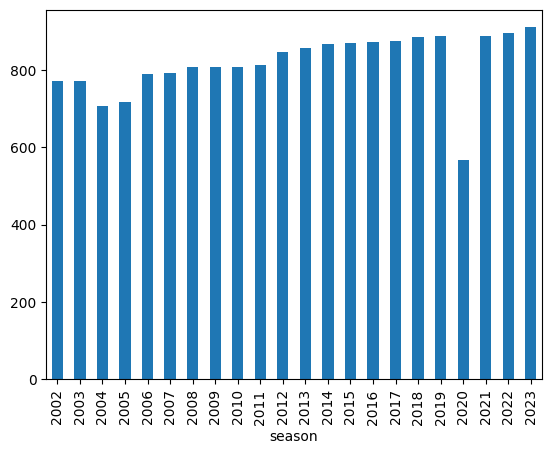

In [2]:
df['season'].value_counts().sort_index().plot(kind='bar')

We have roughly 800 games a year for 21 years; that's a lot of games.

Let's get just the win/loss figures first, and put them in a separate DataFrame.

In [3]:
win_loss_df = df[['season', 'home', 'away', 'score_away', 'score_home']].copy()
win_loss_df['winner'] = win_loss_df.apply(axis='columns', func=lambda x: 'home' if x['score_home'] > x['score_away'] else 'away')
win_loss_df['W'] = win_loss_df.apply(axis='columns', func=lambda x: x['home'] if x['score_home'] > x['score_away'] else x['away'])
win_loss_df['L'] = win_loss_df.apply(axis='columns', func=lambda x: x['home'] if x['score_home'] < x['score_away'] else x['away'])

Which teams have the most losses over the period of interest?

In [4]:
win_loss_df['L'].value_counts().head(n=10).to_frame().T

L,UNLV,New Mexico State,Kansas,Akron,Eastern Michigan,UTEP,Vanderbilt,UL-Monroe,New Mexico,Illinois
count,182,182,177,176,176,174,174,170,170,168


Which teams have the most wins over the period of interest?

In [5]:
win_loss_df['W'].value_counts().head(n=10).to_frame().T

W,Ohio State,Alabama,Georgia,Oklahoma,Boise State,Clemson,LSU,USC,Oregon,Wisconsin
count,244,243,232,231,231,220,216,205,203,202


In [6]:
win_loss_df.head(n=5)

,season,home,away,score_away,score_home,winner,W,L
0,2002,Virginia,Colorado State,35,29,away,Colorado State,Virginia
1,2002,Wisconsin,Fresno State,21,23,home,Wisconsin,Fresno State
2,2002,Ohio State,Texas Tech,21,45,home,Ohio State,Texas Tech
3,2002,NC State,New Mexico,14,34,home,NC State,New Mexico
4,2002,Nebraska,Arizona State,10,48,home,Nebraska,Arizona State


Let's collect each year into its own DataFrame. This will make it easier to calculate each team's results for each season below.

In [7]:
wl = {season: win_loss_df[win_loss_df['season'] == season] for season in win_loss_df['season'].unique().tolist()}

How many distinct home teams do we have?

In [8]:
df['home'].nunique()

139

One of the difficulties with this dataset is that it includes games where an FBS team schedules an FCS team for an early-season win, and probably other complicated situations. We have rather more away teams than home teams, and we have home teams that appear a suspiciously small number of times. 

Let's build the dataset we really want: for each season and team, let's find the games, wins, losses, points scored, and points allowed.

In [9]:
result = []
teams = df['home'].unique().tolist()
for team in teams:
    for season in range(2002, 2023):
        wins = 0
        games = 0
        points_scored = 0
        points_allowed = 0
        home_df = wl[season][wl[season]['home'] == team]
        wins += len(home_df[home_df['winner'] == 'home'])
        games += len(home_df)
        points_scored += home_df['score_home'].sum()
        points_allowed += home_df['score_away'].sum()
        away_df = wl[season][wl[season]['away'] == team]
        wins += len(away_df[away_df['winner'] == 'away'])
        games += len(away_df)
        losses = games - wins
        points_scored += away_df['score_away'].sum()
        points_allowed += away_df['score_home'].sum()
        result.append(pd.Series(data={'season': season, 'team': team, 'games': games, 'wins': wins, 'losses': losses, 
                                      'points scored': points_scored, 'points allowed': points_allowed} ))
result_df = pd.DataFrame(data=result)
result_df.head()

,season,team,games,wins,losses,points scored,points allowed
0,2002,Virginia,14,9,5,402,348
1,2003,Virginia,13,8,5,364,265
2,2004,Virginia,12,8,4,363,212
3,2005,Virginia,12,7,5,320,279
4,2006,Virginia,12,5,7,181,214


Now let's add our Pythagorean expectation and actual winning percentage.

In [10]:
from math import pow

result_df['actual'] = result_df['wins']/result_df['games']
result_df['numerator'] = result_df['points scored'].apply(func=lambda x: pow(x, 2.37))
result_df['denominator'] = result_df['points allowed'].apply(func=lambda x: pow(x, 2.37))
result_df['expected'] = result_df['numerator']/(result_df['numerator'] + result_df['denominator'])
result_df['expected wins'] = result_df['expected'] * result_df['games']
result_df['points total'] = result_df['points scored'] + result_df['points allowed']
result_df.head()

,season,team,games,wins,losses,points scored,points allowed,actual,numerator,denominator,expected,expected wins,points total
0,2002,Virginia,14,9,5,402,348,0.642857,1.485990e+06,1.055706e+06,0.584645,8.185031,750
1,2003,Virginia,13,8,5,364,265,0.615385,1.174384e+06,5.534683e+05,0.679679,8.835821,629
2,2004,Virginia,12,8,4,363,212,0.666667,1.166752e+06,3.261490e+05,0.781533,9.378402,575
3,2005,Virginia,12,7,5,320,279,0.583333,8.653772e+05,6.252907e+05,0.580530,6.966358,599
4,2006,Virginia,12,5,7,181,214,0.416667,2.242323e+05,3.334883e+05,0.402051,4.824616,395


Let's make a big plot of the expected wins (based on the Pythagorean expectation) vs. the actual wins. We expect these two quantities to be positively correlated. And we expect actual wins to be discrete and expected wins to look continuous.

<Axes: xlabel='expected wins', ylabel='wins'>

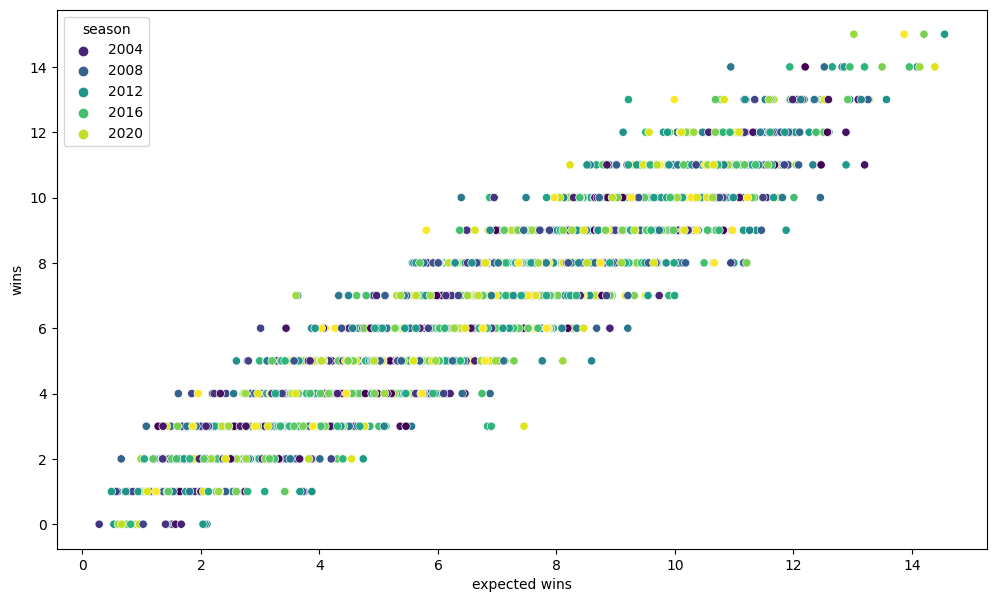

In [11]:
import matplotlib.pyplot as plt
from seaborn import scatterplot

FIGSIZE = (12, 7)
plt.figure(figsize=FIGSIZE)
scatterplot(data=result_df[result_df['games'] > 6], x='expected wins', y='wins', hue='season', palette='viridis')

There's not a great way to visualize the entire dataset; we can show how expected wins vary from season to season, and how actual wins tend to be correlated with expected wins, because the teams that score more tend to win.

<Axes: xlabel='season', ylabel='expected wins'>

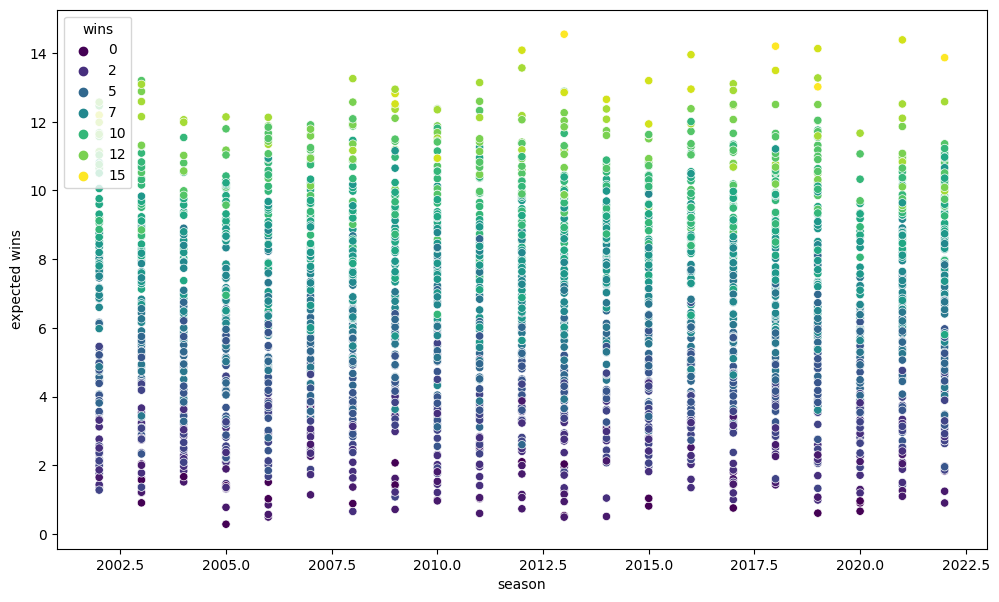

In [12]:
plt.figure(figsize=FIGSIZE)
scatterplot(data=result_df[result_df['games'] > 6], x='season', y='expected wins', hue='wins', palette='viridis')

But maybe it makes more sense to choose a season (later seasons are generally more interesting) and plot expected wins as a function of real wins. Outliers are more interesting than teams that conform to the actual-expected curve, but only in contrast to their actual-win cohort.  

<Axes: xlabel='wins', ylabel='expected wins'>

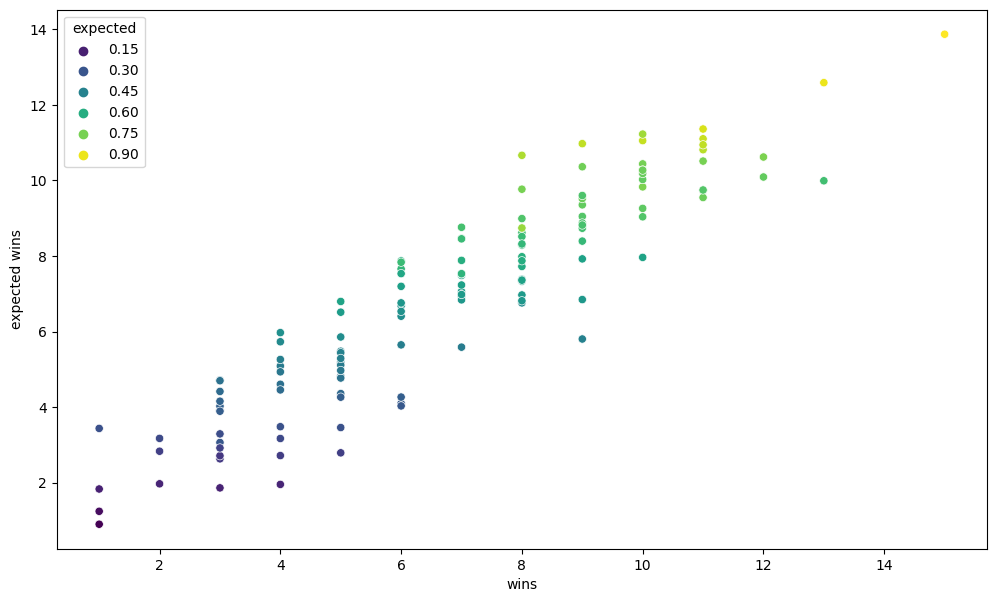

In [13]:
plt.figure(figsize=FIGSIZE)
scatterplot(data=result_df[(result_df['games'] > 6) & (result_df['season'] == 2022)], x='wins', y='expected wins', hue='expected', palette='viridis')

Finally, let's use plotly to add dynamic plots with hover data that includes team names, etc.

In [14]:
from plotly import express

express.strip(data_frame=result_df[result_df['games'] > 6], x='expected wins', y='wins', color='season', hover_name='team', 
                hover_data=['games', 'points scored', 'points allowed'])

In [15]:
express.scatter(data_frame=result_df[(result_df['games'] > 6) & (result_df['season'] == 2022)], x='wins', y='expected wins', color='expected', size='points scored', hover_name='team', hover_data=['points allowed', 'points total'])